In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
df = pd.read_csv('../data/master/master_csv/gt_mastertable.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/master/master_csv/gt_mastertable.csv'

In [ ]:
# Calculate overall finish, DNF, and DNS rates
total = len(df)
status_counts = df['ws_status'].value_counts()
finish_rate = status_counts.get('Finisher', 0) / total
dnf_rate = status_counts.get('DNF', 0) / total
dns_rate = status_counts.get('DNS', 0) / total

overall_rates = {
    'Finish Rate': round(finish_rate, 3),
    'DNF Rate': round(dnf_rate, 3),
    'DNS Rate': round(dns_rate, 3)
}

# Split by gender
gender_split = (
    df.groupby(['gt_gender', 'ws_status'])
      .size()
      .unstack(fill_value=0)
)

gender_split['Total'] = gender_split.sum(axis=1)
for status in ['Finisher', 'DNF', 'DNS']:
    if status in gender_split.columns:
        gender_split[f'{status}_Rate'] = (gender_split[status] / gender_split['Total']).round(3)

# Median ws_time by gender
median_ws_time = df[df['ws_status'] == 'Finisher'].groupby('gt_gender')['ws_time'].median().round(3)

overall_rates, gender_split, median_ws_time

In [7]:
# Calculate median ws_time by gender and year for finishers only
median_ws_time_by_gender_year = (
    df[df['ws_status'] == 'Finisher']
    .groupby(['ws_year', 'gt_gender'])['ws_time']
    .median()
    .unstack()
    .round(3)
    .sort_index()
)

median_ws_time_by_gender_year

gt_gender,F,M
ws_year,,
2022,0.819,0.691
2023,0.758,0.663
2024,0.786,0.638
2025,0.738,0.674


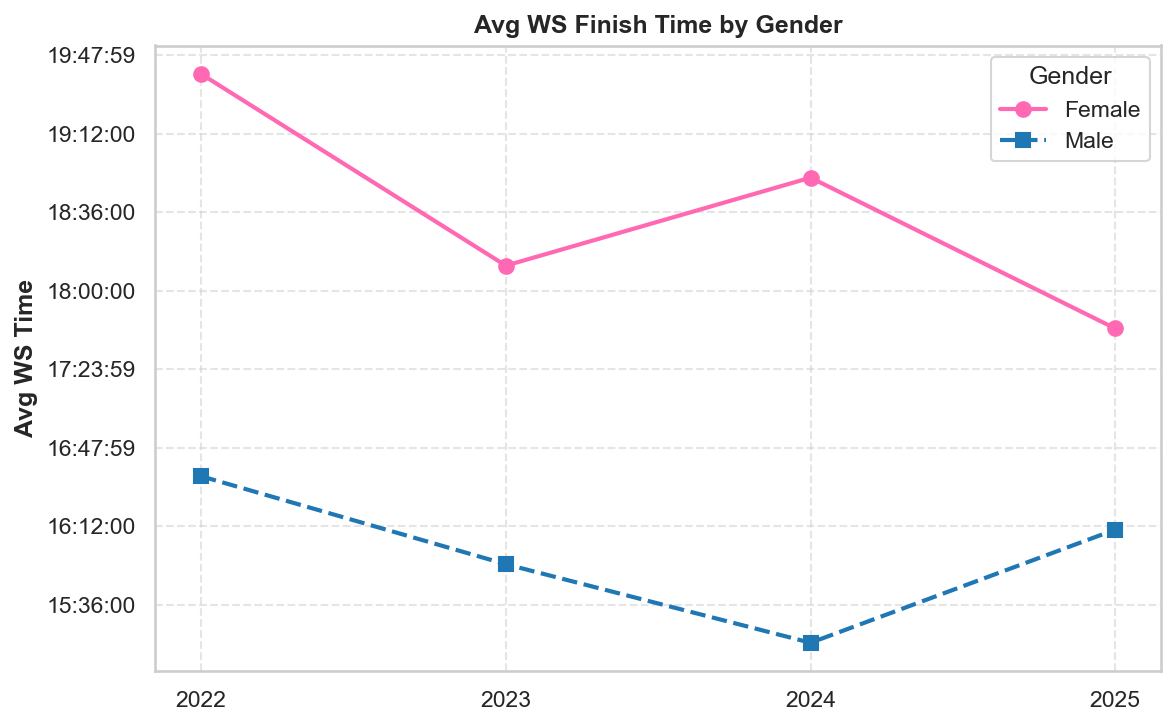

In [63]:
import matplotlib.ticker as ticker


def day_fraction_to_hms(x, pos):
    total_seconds = x * 24 * 3600
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"



# Plot median WS time by gender over the years (line chart)
plt.figure(figsize=(8, 5), dpi=150)

# ✅ Assign gender-specific colors
colors = {'F': '#ff69b4', 'M': '#1f77b4'}  # pink & blue

for gender, style in zip(['F', 'M'], ['o-', 's--']):
    plt.plot(
        median_ws_time_by_gender_year.index,
        median_ws_time_by_gender_year[gender],
        style,
        color=colors[gender],
        label='Female' if gender == 'F' else 'Male',
        linewidth=2,
        markersize=7
    )

plt.title("Avg WS Finish Time by Gender", fontweight='bold')
plt.xlabel('')
plt.ylabel("Avg WS Time", fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Gender")

# ✅ Fix xticks: show integer years only
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(day_fraction_to_hms))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.tight_layout()

plt.savefig('python_images/median_ws_time_by_gender.png', dpi = 300)

plt.show()

In [15]:
# Calculate median ws_gender_rank by gender for finishers only
median_gender_rank = (
    df[df['ws_status'] == 'Finisher']
    .groupby('gt_gender')['ws_gender_rank']
    .median()
    .round(1)
)

median_gender_rank

gt_gender
F    11.0
M    10.0
Name: ws_gender_rank, dtype: float64

In [16]:
# Calculate IQR (Interquartile Range) of ws_gender_rank by gender for finishers
iqr_gender_rank = (
    df[df['ws_status'] == 'Finisher']
    .groupby('gt_gender')['ws_gender_rank']
    .agg(IQR=lambda x: x.quantile(0.75) - x.quantile(0.25))
    .round(1)
)

median_iqr_gender_rank = pd.concat([median_gender_rank, iqr_gender_rank], axis=1)
median_iqr_gender_rank.columns = ['Median', 'IQR']

median_iqr_gender_rank

,Median,IQR
gt_gender,,
F,11.0,7.0
M,10.0,10.2


In [14]:
# Calculate median and IQR of ws_gender_rank by gender and year for finishers
gender_rank_by_year = (
    df[df['ws_status'] == 'Finisher']
    .groupby(['ws_year', 'gt_gender'])['ws_gender_rank']
    .agg(
        Median='median',
        IQR=lambda x: x.quantile(0.75) - x.quantile(0.25)
    )
    .round(1)
    .unstack()
)

gender_rank_by_year

Median        IQR      
gt_gender      F     M    F     M
ws_year                          
2022        11.0  10.0  7.5  10.0
2023        10.0   9.0  8.5  11.0
2024        13.0  11.0  5.5  11.0
2025         7.5   9.0  5.2   6.0

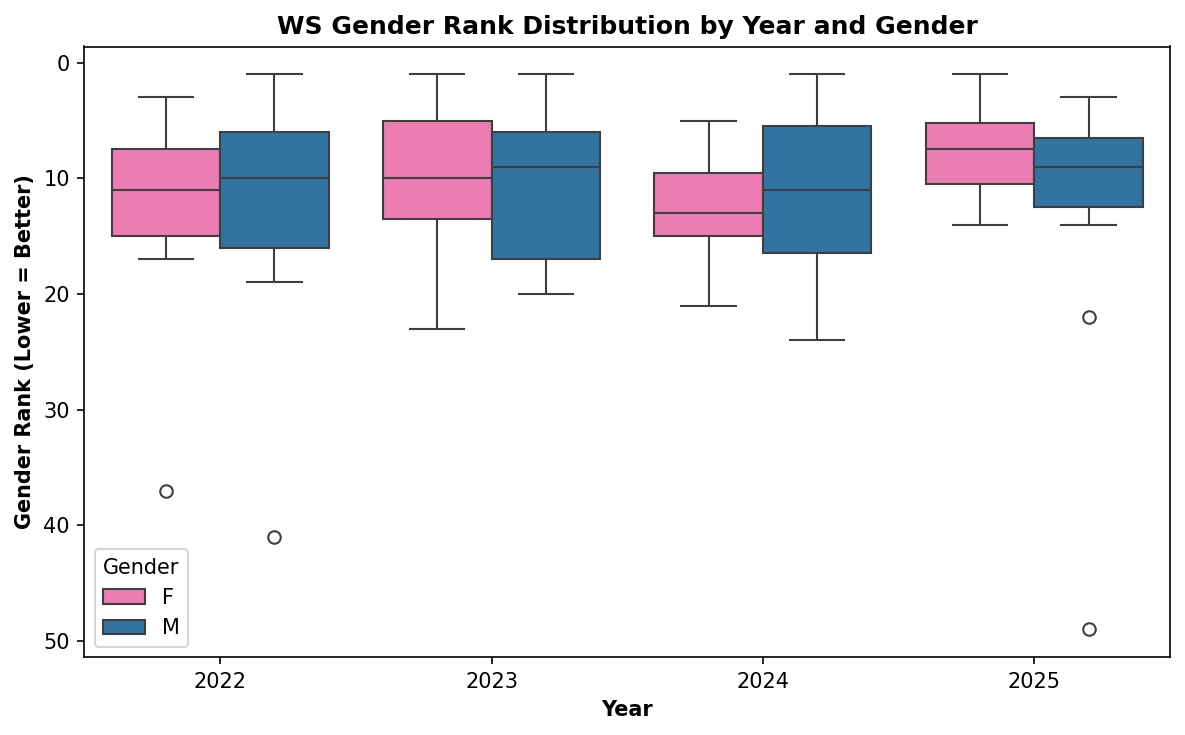

In [18]:
import seaborn as sns

plt.figure(figsize=(8,5), dpi=150)
sns.boxplot(
    data=df[df['ws_status'] == 'Finisher'],
    x='ws_year', y='ws_gender_rank', hue='gt_gender',
    palette={'F': '#ff69b4', 'M': '#1f77b4'})
    
plt.title("WS Gender Rank Distribution by Year and Gender", fontweight='bold')
plt.xlabel("Year", fontweight='bold')
plt.ylabel("Gender Rank (Lower = Better)", fontweight='bold')
plt.gca().invert_yaxis()  # Show better ranks higher
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

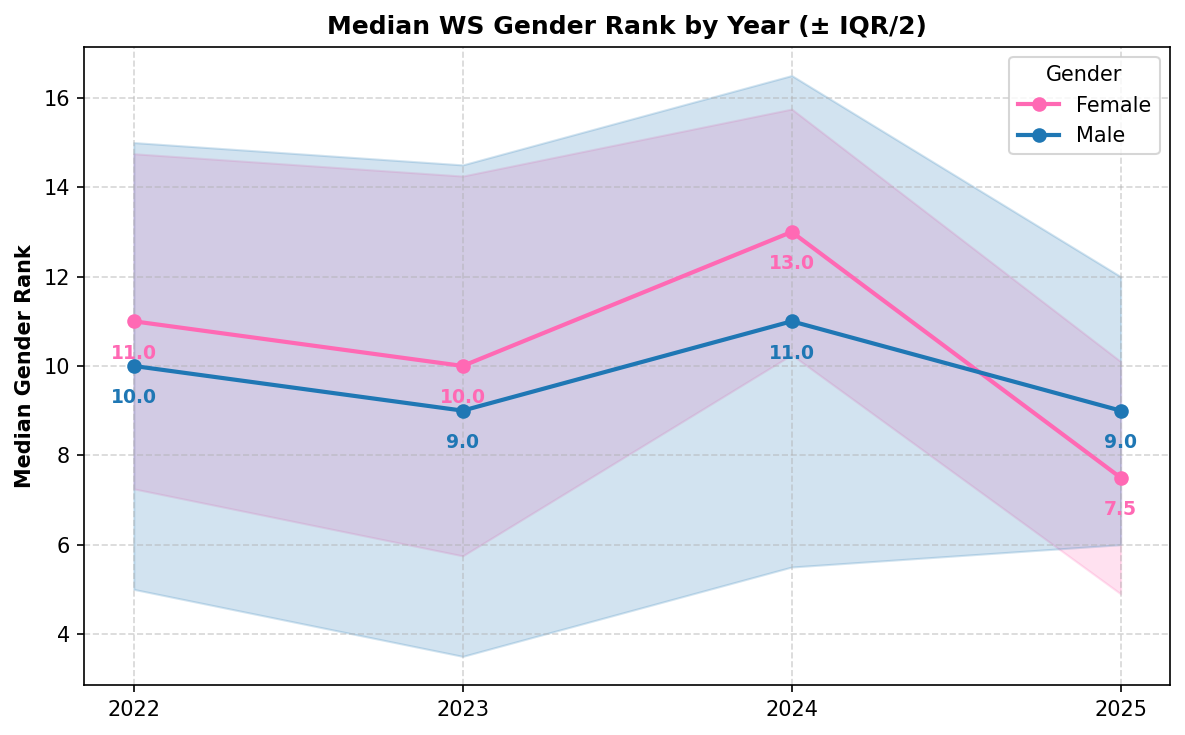

In [25]:
plt.figure(figsize=(8,5), dpi=150)

colors = {'F': '#ff69b4', 'M': '#1f77b4'}

for gender, color in colors.items():
    med = gender_rank_by_year['Median'][gender]
    iqr = gender_rank_by_year['IQR'][gender]

    # Plot median line
    plt.plot(
        med.index, med,
        marker='o',
        color=color,
        linewidth=2,
        label='Female' if gender == 'F' else 'Male'
    )

    # Add shaded IQR region
    plt.fill_between(
        med.index,
        med - iqr/2,
        med + iqr/2,
        color=color,
        alpha=0.2
    )

    # Add data labels for medians
    for x, y in zip(med.index, med):
        plt.text(
            x, y - 0.5,  # slight vertical offset
            f"{y:.1f}",
            ha='center',
            va='top',
            fontsize=9,
            fontweight='bold',
            color=color
        )

plt.title("Median WS Gender Rank by Year (± IQR/2)", fontweight='bold')
plt.xlabel("")
plt.ylabel("Median Gender Rank", fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Gender")
# ✅ Fix xticks: show integer years only
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# plt.gca().invert_yaxis()  # lower rank = better performance
plt.tight_layout()

plt.savefig('python_images/median_ws_gender_rank_by_year_iqr.png', dpi = 300)

plt.show()

In [29]:
# Filter to finishers
finishers = df[df['ws_status'] == 'Finisher'].copy()

# Count entries per nationality
country_counts = finishers['nationality'].value_counts()

# Keep countries with at least 3 finishers (to avoid noise)
valid_countries = country_counts[country_counts >= 2].index

# Median WS performance metrics by nationality and gender
nat_summary = (
    finishers[finishers['nationality'].isin(valid_countries)]
    .groupby(['nationality', 'gt_gender'])
    .agg(
        Median_WS_Time=('ws_time', 'median'),
        Median_Gender_Rank=('ws_gender_rank', 'median'),
        N=('ws_time', 'count')
    )
    .round(3)
    .sort_values('Median_WS_Time')
)

nat_summary

,,Median_WS_Time,Median_Gender_Rank,N
nationality,gt_gender,,,
GBR,M,0.611,1.0,1
NOR,M,0.623,6.0,3
NZL,M,0.640,5.0,1
USA,M,0.664,10.0,31
FRA,M,0.683,6.5,4
CHN,M,0.687,15.5,2
DEU,M,0.691,10.5,2
NOR,F,0.702,5.0,1
GBR,F,0.724,5.0,1


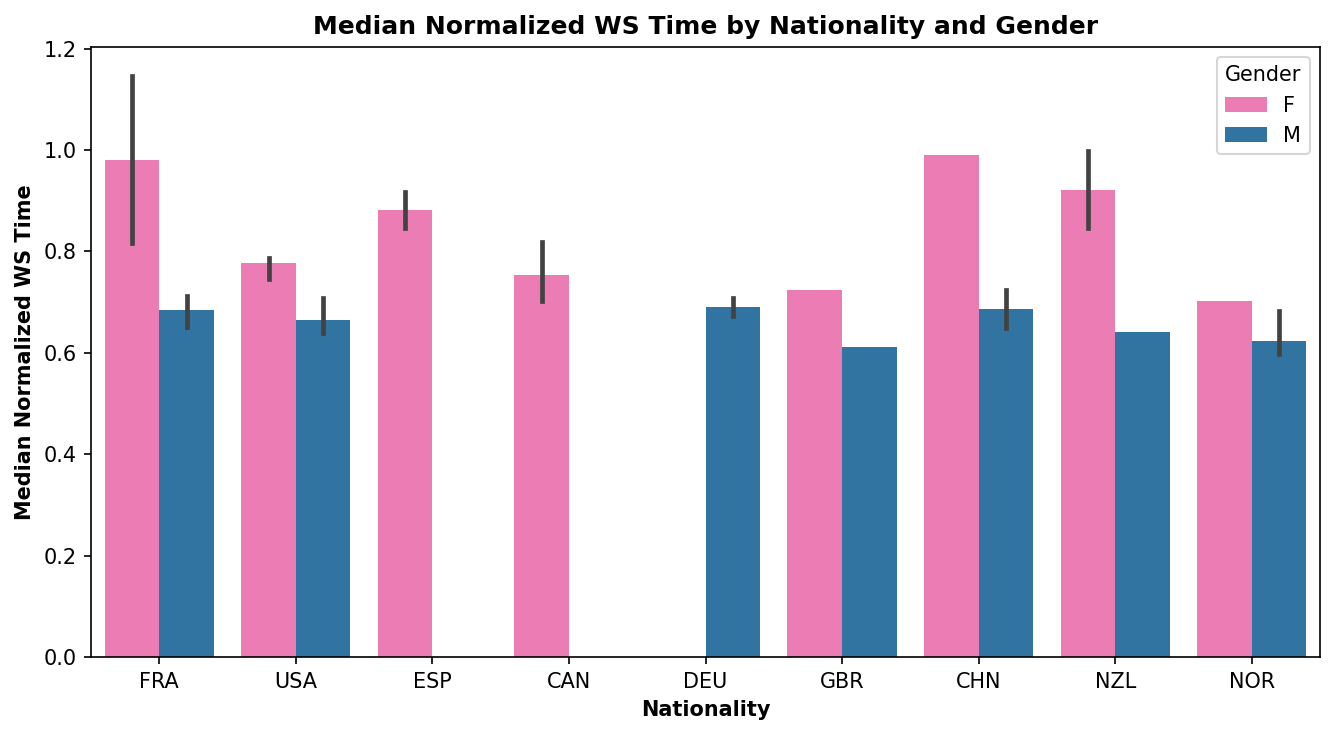

In [30]:
import seaborn as sns
plt.figure(figsize=(9,5), dpi=150)
sns.barplot(
    data=finishers[finishers['nationality'].isin(valid_countries)],
    x='nationality', y='ws_time', hue='gt_gender',
    estimator='median', palette={'F': '#ff69b4', 'M': '#1f77b4'}
)
plt.title("Median Normalized WS Time by Nationality and Gender", fontweight='bold')
plt.xlabel("Nationality", fontweight='bold')
plt.ylabel("Median Normalized WS Time", fontweight='bold')
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

In [31]:
# Create a new column for domestic (USA) vs international
df['region'] = df['nationality'].apply(lambda x: 'Domestic' if x == 'USA' else 'International')

# Filter for finishers only
finishers = df[df['ws_status'] == 'Finisher'].copy()

# Calculate median ws_time and ws_gender_rank by region and gender
region_summary = (
    finishers.groupby(['region', 'gt_gender'])
    .agg(
        Median_WS_Time=('ws_time', 'median'),
        Median_Gender_Rank=('ws_gender_rank', 'median'),
        N=('ws_time', 'count')
    )
    .round(3)
)

region_summary

Median_WS_Time  Median_Gender_Rank   N
region        gt_gender                                        
Domestic      F                   0.778                10.0  21
              M                   0.664                10.0  31
International F                   0.808                11.0  22
              M                   0.681                10.0  17

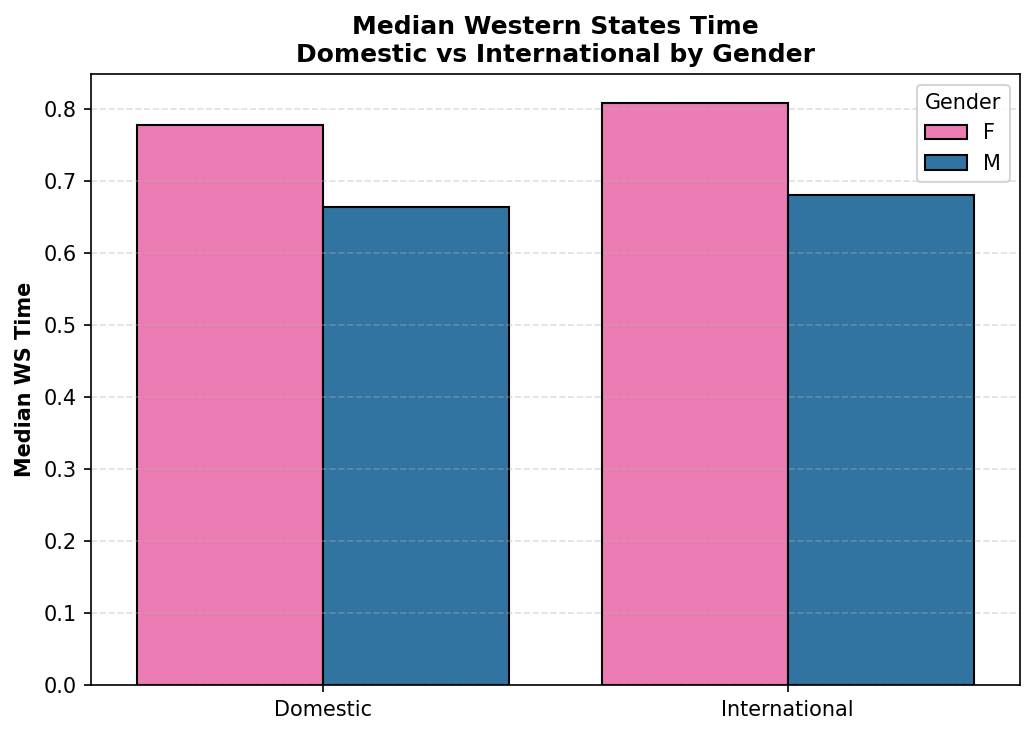

In [34]:
# Reset index for plotting
region_plot = region_summary.reset_index()

plt.figure(figsize=(7, 5), dpi=150)
sns.barplot(
    data=region_plot,
    x='region',
    y='Median_WS_Time',
    hue='gt_gender',
    palette={'F': '#ff69b4', 'M': '#1f77b4'},
    edgecolor='black'
)

plt.title("Median Western States Time\nDomestic vs International by Gender", fontweight='bold')
plt.xlabel("")
plt.ylabel("Median WS Time", fontweight='bold')
plt.legend(title="Gender")
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()

plt.savefig('python_images/median_ws_time_dom_vs_int.png', dpi = 300)

plt.show()

In [45]:
df = pd.read_csv('../data/master/gpx_summary_master.csv')

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

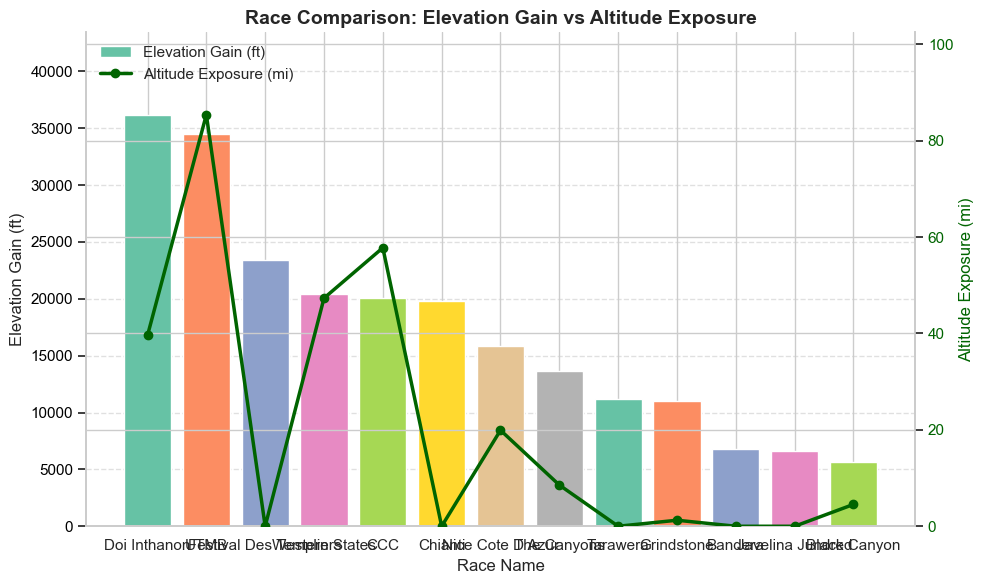

In [54]:
# Sort by elevation or race name if needed
df = df.sort_values("elevation_gain_ft", ascending=False)

sns.set_theme(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart (Elevation Gain)
bars = ax1.bar(
    df['Race Name'],
    df['elevation_gain_ft'],
    color=sns.color_palette("Set2", len(df)),
    label="Elevation Gain (ft)",
    zorder=2
)
ax1.set_ylabel("Elevation Gain (ft)", fontsize=12)
ax1.set_xlabel("Race Name", fontsize=12)
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, df['elevation_gain_ft'].max() * 1.2)
ax1.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=0)

# Add Altitude Exposure line (second y-axis)
ax2 = ax1.twinx()
ax2.plot(
    df['Race Name'],
    df['altitude_exposure_mi'],
    color='darkgreen',
    marker='o',
    linewidth=2.5,
    label="Altitude Exposure (mi)",
    zorder=3
)
ax2.set_ylabel("Altitude Exposure (mi)", fontsize=12, color='darkgreen')
ax2.tick_params(axis='y', labelcolor='darkgreen')
ax2.set_ylim(0, df['altitude_exposure_mi'].max() * 1.2)

# Legends and formatting
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', frameon=False)

# Clean up
sns.despine(right=False, top=True)
plt.xticks(rotation=30, ha='right')
plt.title("Race Comparison: Elevation Gain vs Altitude Exposure", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [66]:
df = pd.read_csv('../data/master/excel_workbooks/gt_ws_perf_for_power_bi.csv')

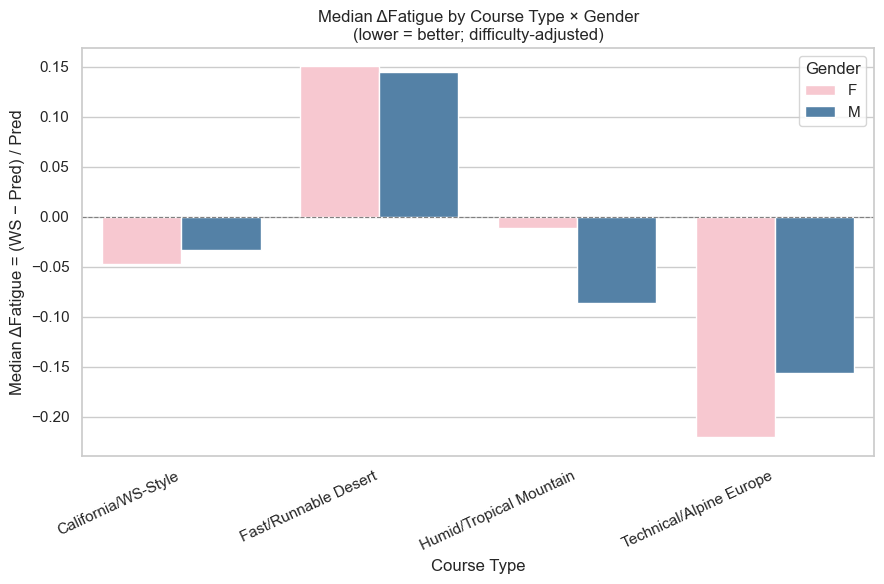

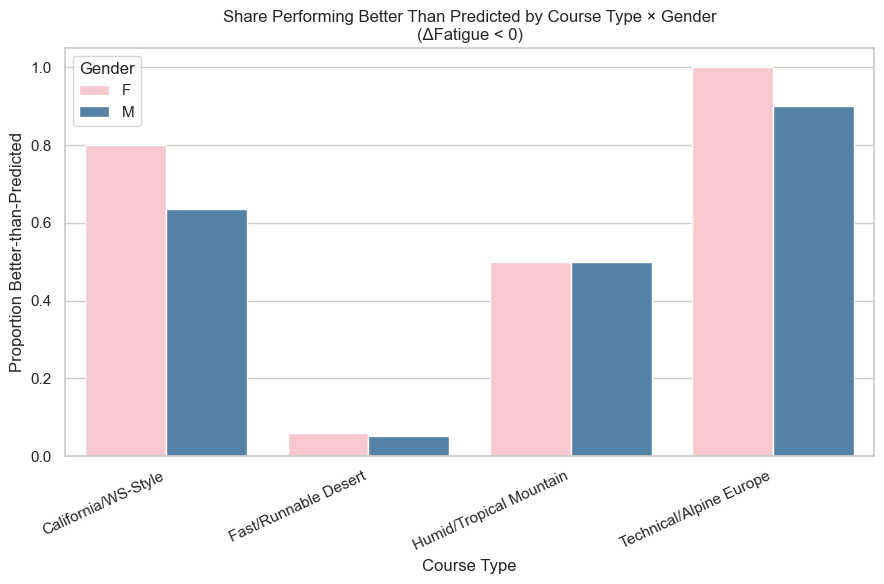

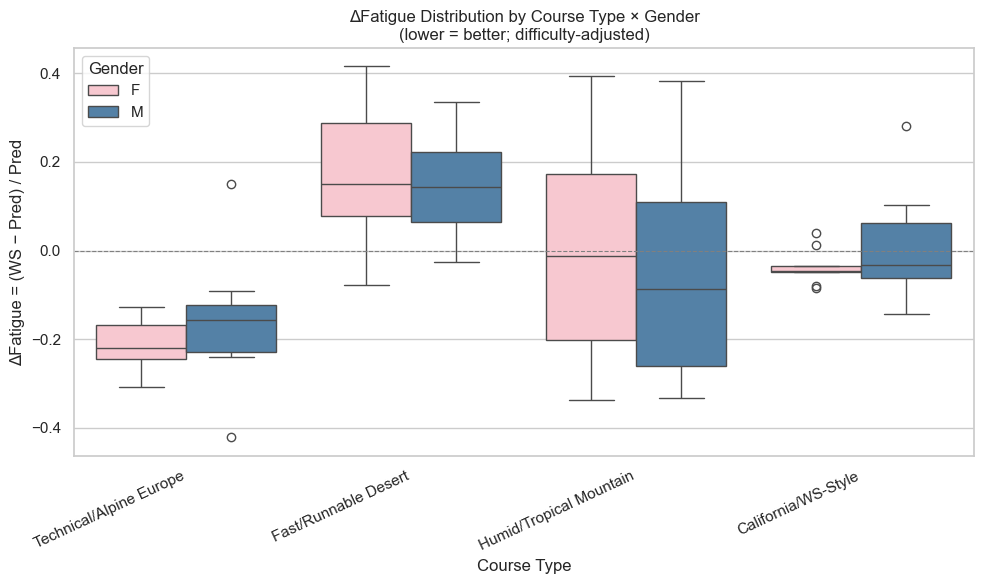

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 1) Course-type map
course_map = {
    'Black Canyon': 'Fast/Runnable Desert',
    'Javelina': 'Fast/Runnable Desert',
    'Bandera': 'Fast/Runnable Desert',

    'Western States': 'California/WS-Style',
    'The Canyons': 'California/WS-Style',
    'Grindstone': 'California/WS-Style',

    'UTMB': 'Technical/Alpine Europe',
    'CCC': 'Technical/Alpine Europe',
    'Festival Des Templiers': 'Technical/Alpine Europe',
    'Nice Cote d Azur': 'Technical/Alpine Europe',

    'Doi Inthanon': 'Humid/Tropical Mountain',
    'Tarawera': 'Humid/Tropical Mountain',
    'Chianti (UTCC)': 'Humid/Tropical Mountain'
}
col_race = "gt_race_name" if "gt_race_name" in df.columns else "race_name"
col_gender = "gt_gender" if "gt_gender" in df.columns else "gender"
df["course_type"] = df[col_race].map(course_map)

# 2) Time parsing
def parse_time_to_seconds(val):
    if pd.isna(val):
        return np.nan
    s = str(val)
    if ":" in s:
        try:
            h, m, sec = s.split(":")
            return int(h)*3600 + int(m)*60 + int(float(sec))
        except Exception:
            pass
    try:
        f = float(s)
        return f * 24 * 3600  # fraction of a day → seconds
    except Exception:
        return np.nan

df["gt_sec"] = df["gt_time"].apply(parse_time_to_seconds) if "gt_time" in df.columns else np.nan
df["ws_sec"] = df["ws_time"].apply(parse_time_to_seconds) if "ws_time" in df.columns else np.nan

# Distances
distance_map = {
    "Nice Cote d Azur": 111.0,
    "Chianti (UTCC)": 103.0,
    "The Canyons": 100.0,
    "Black Canyon": 101.0,
    "Javelina": 159.2,
    "Grindstone": 100.0,
    "UTMB": 174.0,
    "CCC": 100.0,
    "Tarawera": 102.0,
    "Bandera": 100.0,
    "Doi Inthanon": 160.0,
    "Festival Des Templiers": 80.6
}
df["gt_distance_km"] = df[col_race].map(distance_map)
df["ws_distance_km"] = 160.9

# 3) Fit Riegel (by gender), optionally controlling for diff_index
use_diff = "diff_index" in df.columns
if use_diff:
    df["diff_index"] = pd.to_numeric(df["diff_index"], errors="coerce")

params_by_gender = {}
for g in ["M", "F"]:
    needed = ["gt_sec", "ws_sec", "gt_distance_km"]
    if use_diff:
        needed.append("diff_index")
    sub = df[(df[col_gender] == g)].dropna(subset=needed).copy()
    if sub.empty:
        continue
    sub["log_ratio"] = np.log(sub["ws_sec"]/sub["gt_sec"])
    sub["log_dist_ratio"] = np.log(sub["ws_distance_km"]/sub["gt_distance_km"])
    X_cols = ["log_dist_ratio"] + (["diff_index"] if use_diff else [])
    X = sm.add_constant(sub[X_cols])
    y = sub["log_ratio"]
    res = sm.OLS(y, X).fit()
    params = {"alpha": res.params.get("const", 0.0), "k": res.params.get("log_dist_ratio", 0.0)}
    if use_diff:
        params["beta_diff"] = res.params.get("diff_index", 0.0)
    params_by_gender[g] = params

# 4) Predict WS time + delta_fatigue
def predict_ws_time_diffadj(row):
    p = params_by_gender.get(row.get(col_gender))
    if p is None or pd.isna(row.get("gt_sec")) or pd.isna(row.get("gt_distance_km")):
        return np.nan
    log_dist = np.log(row.get("ws_distance_km") / row.get("gt_distance_km"))
    log_ratio = p["alpha"] + p["k"] * log_dist
    if use_diff and not pd.isna(row.get("diff_index")):
        log_ratio += p.get("beta_diff", 0.0) * row.get("diff_index")
    return row.get("gt_sec") * np.exp(log_ratio)

df["ws_pred_sec"] = df.apply(predict_ws_time_diffadj, axis=1)
df["delta_fatigue"] = (df["ws_sec"] - df["ws_pred_sec"]) / df["ws_pred_sec"]

# 5) Summaries (adjusted only)
finishers = df[(df["ws_status"] == "Finisher") & df["delta_fatigue"].notna() & df["course_type"].notna()].copy()

summary_adj = (
    finishers.groupby(["course_type", col_gender])
      .agg(
          n_finishers=("ws_sec", "count"),
          median_delta=("delta_fatigue", "median"),
          mean_delta=("delta_fatigue", "mean"),
          pct_better=("delta_fatigue", lambda x: (x < 0).mean()),
          median_ws_gender_rank=("ws_gender_rank", "median")
      )
      .reset_index()
      .sort_values(["course_type", col_gender])
)


# 6) Visuals — adjusted only
plt.figure(figsize=(9,6))
sns.barplot(data=summary_adj, x="course_type", y="median_delta", hue=col_gender, palette={"F":"pink","M":"steelblue"})
plt.axhline(0, linestyle="--", linewidth=0.8, color="gray")
plt.title("Median ΔFatigue by Course Type × Gender\n(lower = better; difficulty-adjusted)")
plt.ylabel("Median ΔFatigue = (WS − Pred) / Pred")
plt.xlabel("Course Type")
plt.xticks(rotation=25, ha='right')
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
sns.barplot(data=summary_adj, x="course_type", y="pct_better", hue=col_gender, palette={"F":"pink","M":"steelblue"})
plt.title("Share Performing Better Than Predicted by Course Type × Gender\n(ΔFatigue < 0)")
plt.ylabel("Proportion Better-than-Predicted")
plt.xlabel("Course Type")
plt.xticks(rotation=25, ha='right')
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=finishers, x="course_type", y="delta_fatigue", hue=col_gender, palette={"F":"pink","M":"steelblue"})
plt.axhline(0, linestyle="--", linewidth=0.8, color="gray")
plt.title("ΔFatigue Distribution by Course Type × Gender\n(lower = better; difficulty-adjusted)")
plt.ylabel("ΔFatigue = (WS − Pred) / Pred")
plt.xlabel("Course Type")
plt.xticks(rotation=25, ha='right')
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

Spearman correlation between ΔFatigue and WS Gender Rank: r = 0.377, p = 0.0002


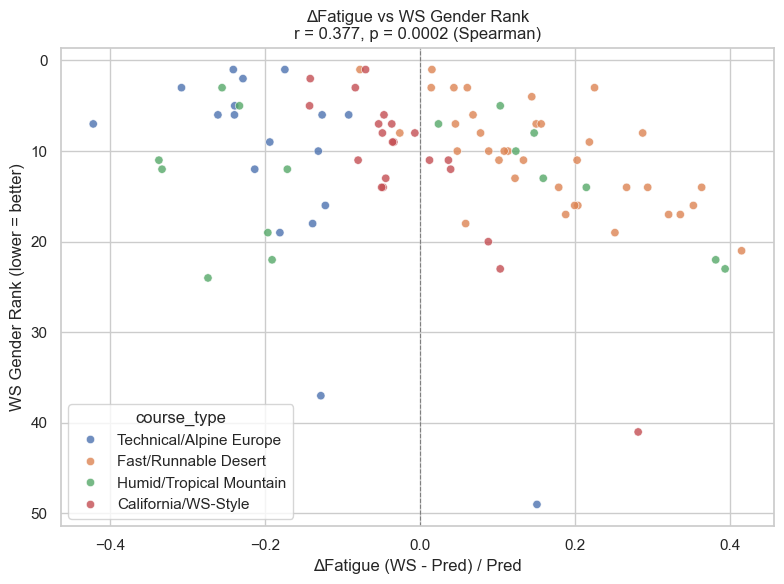

In [70]:
import scipy.stats as stats

# Keep finishers with valid values
valid = finishers.dropna(subset=["delta_fatigue", "ws_gender_rank"]).copy()

# Compute correlation
r, p = stats.spearmanr(valid["delta_fatigue"], valid["ws_gender_rank"])

print(f"Spearman correlation between ΔFatigue and WS Gender Rank: r = {r:.3f}, p = {p:.4f}")

# Optional: visualize
plt.figure(figsize=(8,6))
sns.scatterplot(data=valid, x="delta_fatigue", y="ws_gender_rank", hue="course_type", alpha=0.8)
plt.axvline(0, linestyle="--", color="gray", linewidth=0.8)
plt.title(f"ΔFatigue vs WS Gender Rank\nr = {r:.3f}, p = {p:.4f} (Spearman)")
plt.xlabel("ΔFatigue (WS - Pred) / Pred")
plt.ylabel("WS Gender Rank (lower = better)")
plt.gca().invert_yaxis()  # since rank 1 is best
plt.tight_layout()
plt.show()

In [71]:
for c in valid["course_type"].unique():
    sub = valid[valid["course_type"] == c]
    r, p = stats.spearmanr(sub["delta_fatigue"], sub["ws_gender_rank"])
    print(f"{c}: r = {r:.3f}, p = {p:.4f}, n = {len(sub)}")

Technical/Alpine Europe: r = 0.523, p = 0.0259, n = 18
Fast/Runnable Desert: r = 0.645, p = 0.0000, n = 36
Humid/Tropical Mountain: r = 0.237, p = 0.3762, n = 16
California/WS-Style: r = 0.698, p = 0.0004, n = 21



Overall correlation between ΔFatigue and WS Gender Rank:
Spearman r = 0.377, p = 0.0002 (n = 91)
M: r = 0.387, p = 0.0065, n = 48
F: r = 0.381, p = 0.0117, n = 43

Correlation by Course Type × Gender:
Technical/Alpine Europe   M  n=10   r=0.443   p=0.1996
Technical/Alpine Europe   F  n= 8   r=0.762   p=0.0280
Fast/Runnable Desert      M  n=19   r=0.454   p=0.0509
Fast/Runnable Desert      F  n=17   r=0.836   p=0.0000
Humid/Tropical Mountain   M  n= 8   r=-0.071   p=0.8665
Humid/Tropical Mountain   F  n= 8   r=0.619   p=0.1017
California/WS-Style       M  n=11   r=0.900   p=0.0002
California/WS-Style       F  n=10   r=0.183   p=0.6130


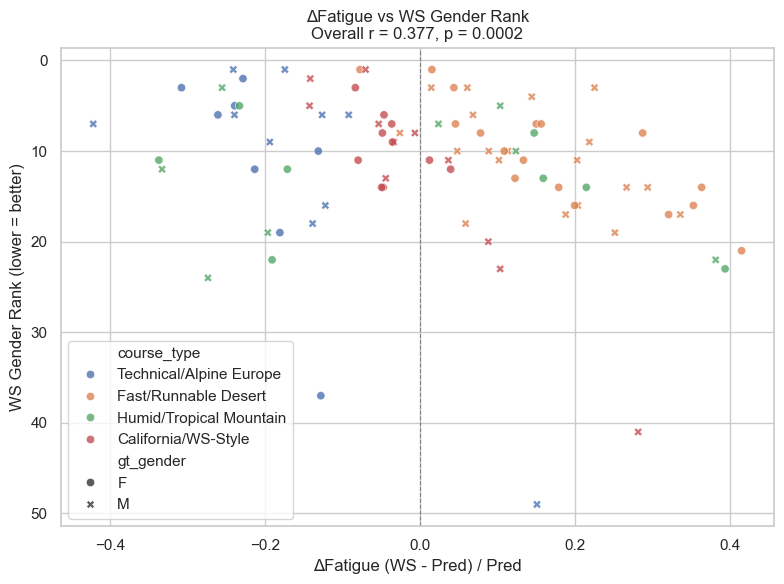

In [72]:
# ================================================
# 9) ΔFatigue vs WS Gender Rank Correlation Tests
# ================================================
import scipy.stats as stats

valid = finishers.dropna(subset=["delta_fatigue", "ws_gender_rank"]).copy()

# ---- Overall correlation ----
r_overall, p_overall = stats.spearmanr(valid["delta_fatigue"], valid["ws_gender_rank"])
print(f"\nOverall correlation between ΔFatigue and WS Gender Rank:")
print(f"Spearman r = {r_overall:.3f}, p = {p_overall:.4f} (n = {len(valid)})")

# ---- By gender ----
for g in ["M", "F"]:
    sub = valid[valid[col_gender] == g]
    if len(sub) >= 5:
        r, p = stats.spearmanr(sub["delta_fatigue"], sub["ws_gender_rank"])
        print(f"{g}: r = {r:.3f}, p = {p:.4f}, n = {len(sub)}")
    else:
        print(f"{g}: not enough data (n={len(sub)})")

# ---- By course type × gender ----
print("\nCorrelation by Course Type × Gender:")
rows = []
for c in valid["course_type"].unique():
    for g in ["M", "F"]:
        sub = valid[(valid["course_type"] == c) & (valid[col_gender] == g)]
        if len(sub) >= 4:
            r, p = stats.spearmanr(sub["delta_fatigue"], sub["ws_gender_rank"])
            rows.append((c, g, len(sub), r, p))
            print(f"{c:25} {g}  n={len(sub):2d}   r={r:.3f}   p={p:.4f}")
        else:
            print(f"{c:25} {g}  n={len(sub):2d}   insufficient data")

# ---- Scatter plot ----
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=valid,
    x="delta_fatigue",
    y="ws_gender_rank",
    hue="course_type",
    style=col_gender,
    alpha=0.8
)
plt.axvline(0, linestyle="--", color="gray", linewidth=0.8)
plt.gca().invert_yaxis()  # rank 1 is best
plt.title(f"ΔFatigue vs WS Gender Rank\nOverall r = {r_overall:.3f}, p = {p_overall:.4f}")
plt.xlabel("ΔFatigue (WS - Pred) / Pred")
plt.ylabel("WS Gender Rank (lower = better)")
plt.tight_layout()
plt.show()

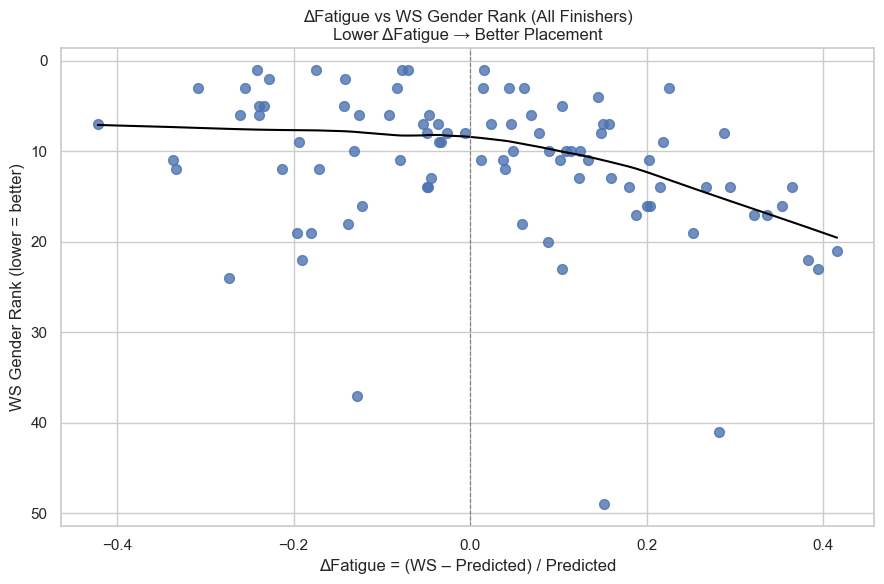

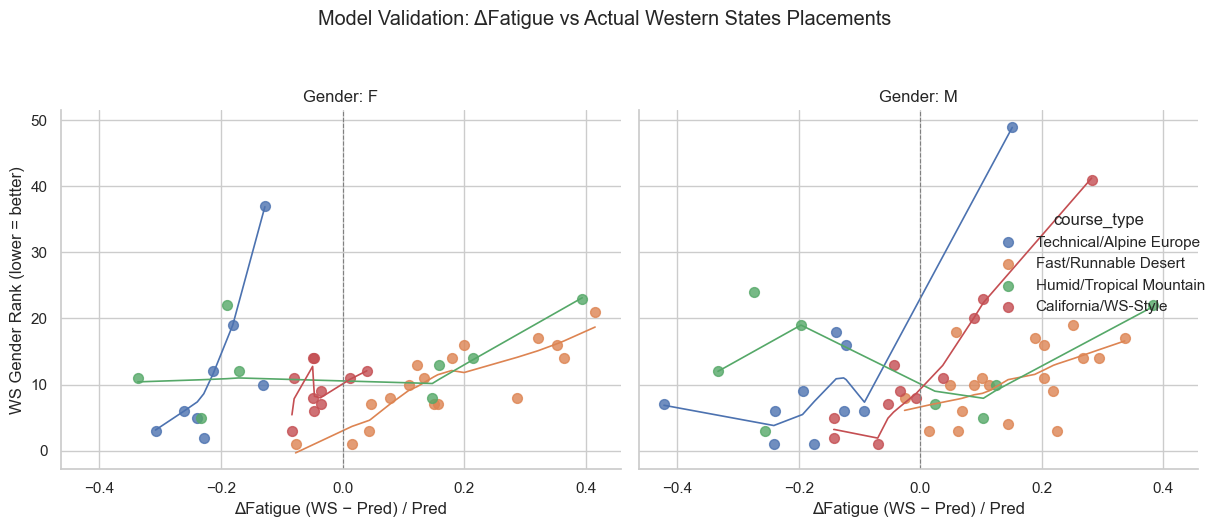

,Course Type,Gender,n,Spearman r,p-value
0,Technical/Alpine Europe,M,10,0.443,0.1996
1,Technical/Alpine Europe,F,8,0.762,0.0280
2,Fast/Runnable Desert,M,19,0.454,0.0509
3,Fast/Runnable Desert,F,17,0.836,0.0000
4,Humid/Tropical Mountain,M,8,-0.071,0.8665
5,Humid/Tropical Mountain,F,8,0.619,0.1017
6,California/WS-Style,M,11,0.900,0.0002
7,California/WS-Style,F,10,0.183,0.6130


In [73]:
# =====================================================
# ΔFatigue vs WS Gender Rank — Validation Visualization
# =====================================================
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Filter valid data
valid = finishers.dropna(subset=["delta_fatigue", "ws_gender_rank"]).copy()

# --- Overall scatter with regression line ---
plt.figure(figsize=(9, 6))
sns.regplot(
    data=valid,
    x="delta_fatigue",
    y="ws_gender_rank",
    scatter_kws={"alpha": 0.8, "s": 50},
    line_kws={"color": "black", "lw": 1.5},
    lowess=True
)
plt.gca().invert_yaxis()  # Rank 1 is best
plt.axvline(0, color="gray", linestyle="--", lw=0.8)
plt.title("ΔFatigue vs WS Gender Rank (All Finishers)\nLower ΔFatigue → Better Placement")
plt.xlabel("ΔFatigue = (WS – Predicted) / Predicted")
plt.ylabel("WS Gender Rank (lower = better)")
plt.tight_layout()
plt.show()

# --- Colored by course type + gender facet ---
g = sns.lmplot(
    data=valid,
    x="delta_fatigue",
    y="ws_gender_rank",
    hue="course_type",
    col=col_gender,
    height=5,
    aspect=1,
    scatter_kws={"alpha":0.8, "s":50},
    line_kws={"lw":1.2},
    lowess=True
)
for ax in g.axes.flat:
    ax.axvline(0, linestyle="--", color="gray", lw=0.8)
    ax.invert_yaxis()
g.set_titles("Gender: {col_name}")
g.set_axis_labels("ΔFatigue (WS − Pred) / Pred", "WS Gender Rank (lower = better)")
plt.suptitle("Model Validation: ΔFatigue vs Actual Western States Placements", y=1.05)
plt.tight_layout()
plt.show()

# --- Optional: summary stats table for plotting text ---
corr_summary = []
for c in valid["course_type"].unique():
    for g in ["M", "F"]:
        sub = valid[(valid["course_type"] == c) & (valid[col_gender] == g)]
        if len(sub) >= 4:
            r, p = stats.spearmanr(sub["delta_fatigue"], sub["ws_gender_rank"])
            corr_summary.append([c, g, len(sub), round(r, 3), round(p, 4)])
corr_df = pd.DataFrame(corr_summary, columns=["Course Type", "Gender", "n", "Spearman r", "p-value"])
display(corr_df)

In [26]:
df = pd.read_csv('../data/master/golden_ticket_recipient_master_table.csv')

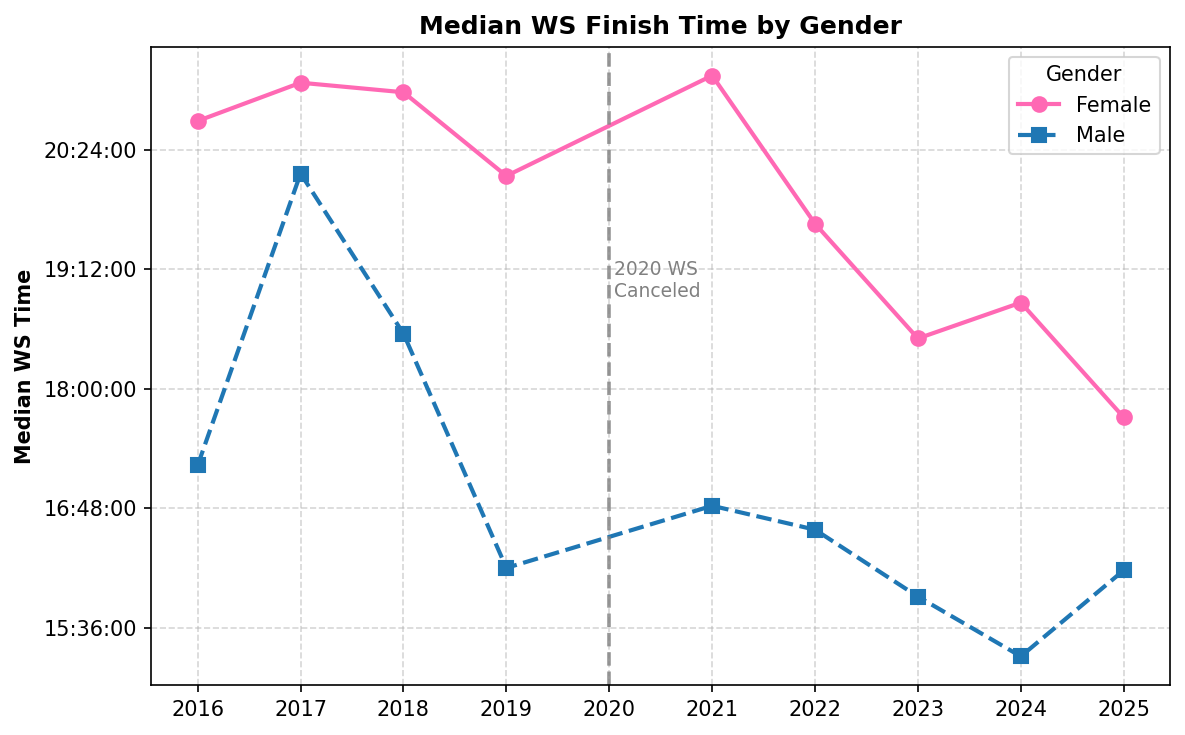

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# --- 1. Clean / prep -------------------------------------------------

df['WS_Finish_Time'] = pd.to_numeric(df['WS_Finish_Time'], errors='coerce')
df['WS_Year'] = df['WS_Year'].astype('Int64')

df['ws_status'] = np.select(
    [
        df['WS_Finisher_Flag'] == True,
        df['WS_DNF_Flag'] == True,
        df['WS_DNS_Flag'] == True
    ],
    ['Finisher', 'DNF', 'DNS'],
    default='Unknown'
)

df['gt_gender'] = df['Gender']
df['ws_time']   = df['WS_Finish_Time']
df['ws_year']   = df['WS_Year']

# --- 2. Exclude WS 2026 (future race, no meaningful results yet) -----
df_filtered = df[df['ws_year'] != 2026]

# --- 3. Median WS Time by gender & year -------------------------------

median_ws_time_by_gender_year = (
    df_filtered[df_filtered['ws_status'] == 'Finisher']
    .groupby(['ws_year', 'gt_gender'])['ws_time']
    .median()
    .unstack()
    .round(3)
    .sort_index()
)

# --- 4. Plot -----------------------------------------------------------

def day_fraction_to_hms(x, pos):
    total_seconds = x * 24 * 3600
    hours   = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"


plt.figure(figsize=(8, 5), dpi=150)

colors = {'F': '#ff69b4', 'M': '#1f77b4'}

for gender, style in zip(['F', 'M'], ['o-', 's--']):
    if gender in median_ws_time_by_gender_year.columns:
        plt.plot(
            median_ws_time_by_gender_year.index,
            median_ws_time_by_gender_year[gender],
            style,
            color=colors[gender],
            label='Female' if gender == 'F' else 'Male',
            linewidth=2,
            markersize=7
        )

# --- 5. Add reference line at 2020 (WS canceled) ----------------------

plt.axvline(
    x=2020,
    color='gray',
    linestyle='--',
    linewidth=1.75,
    alpha=0.8
)

plt.text(
    2020 + 0.05,
    plt.gca().get_ylim()[1] * 0.90,
    "2020 WS\nCanceled",
    color='gray',
    fontsize=9,
    ha='left',
    va='top'
)

# --- 6. Labels ---------------------------------------------------------

plt.title("Median WS Finish Time by Gender", fontweight='bold')
plt.ylabel("Median WS Time", fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Gender")

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(day_fraction_to_hms))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()

plt.savefig('python_images/median_ws_finish_time_by_gender_16_25.png', dpi = 400)

plt.show()


In [59]:
df = pd.read_csv('../data/master/golden_ticket_recipient_master_table.csv')

In [60]:
# --- Compute gender ranks only for WS finishers ---
df_rank = df_filtered[df_filtered['ws_status'] == 'Finisher'].copy()

df_rank['WS_Gender_Rank'] = df_rank['WS_Gender_Rank']

# --- Build summary table: Median and IQR by year and gender ---
gender_rank_by_year = (
    df_rank
    .groupby(['ws_year', 'gt_gender'])['WS_Gender_Rank']
    .agg(
        Median='median',
        Q1=lambda x: x.quantile(0.25),
        Q3=lambda x: x.quantile(0.75)
    )
)

# Add IQR
gender_rank_by_year['IQR'] = gender_rank_by_year['Q3'] - gender_rank_by_year['Q1']

# Move gt_gender from index into columns (MultiIndex: stat → gender)
gender_rank_by_year = gender_rank_by_year.unstack('gt_gender').sort_index()


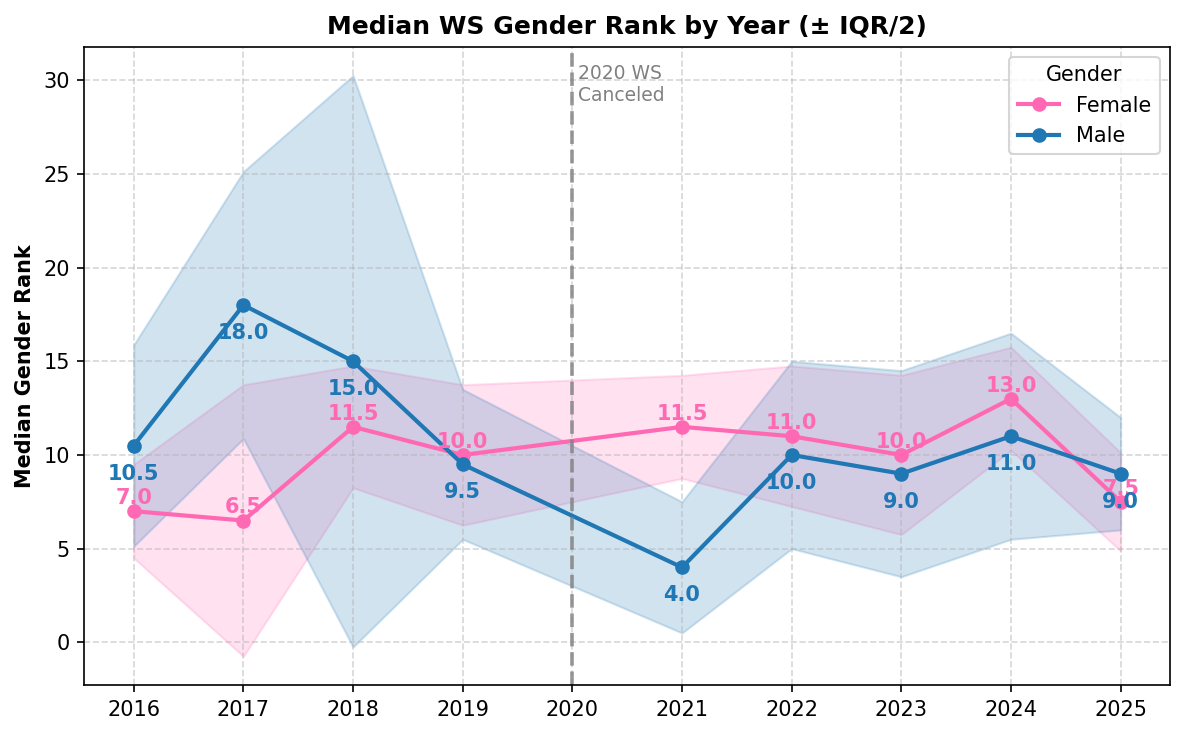

In [63]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# --- 1. Exclude 2026 from the gender-rank summary table ---
gender_rank_by_year_excl = gender_rank_by_year.loc[gender_rank_by_year.index != 2026]

plt.figure(figsize=(8, 5), dpi=150)

colors = {'F': '#ff69b4', 'M': '#1f77b4'}

# --- 2. Plot median line + IQR shading for each gender ---
for gender, color in colors.items():
    med = gender_rank_by_year_excl['Median'][gender]
    iqr = gender_rank_by_year_excl['IQR'][gender]

    # Median line
    plt.plot(
        med.index,
        med,
        marker='o',
        color=color,
        linewidth=2,
        label='Female' if gender == 'F' else 'Male'
    )

    # IQR/2 shaded region
    plt.fill_between(
        med.index,
        med - iqr / 2,
        med + iqr / 2,
        color=color,
        alpha=0.2
    )

    # Labels for the medians
    offset = {'F': 0.7, 'M': -1.5}   # shift labels up for F, down for M slightly

    for x, y in zip(med.index, med):
        plt.text(
            x, 
            y + offset[gender],   # apply gender-specific offset
            f"{y:.1f}",
            ha='center',
            va='center',
            fontsize=10,
            fontweight='bold',
            color=color
    )


# --- 3. Add vertical line + label at 2020 (WS canceled) ---
plt.axvline(
    x=2020,
    color='gray',
    linestyle='--',
    linewidth=1.75,
    alpha=0.8
)

ymin, ymax = plt.gca().get_ylim()
plt.text(
    2020 + 0.05,
    ymax * 0.97,
    "2020 WS\nCanceled",
    color='gray',
    fontsize=9,
    ha='left',
    va='top'
)

# --- 4. Plot decoration ---
plt.title("Median WS Gender Rank by Year (± IQR/2)", fontweight='bold')
plt.xlabel("")
plt.ylabel("Median Gender Rank", fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Gender")

plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()

plt.savefig('python_images/median_ws_gender_rank_by_year_16_25.png', dpi = 400)

plt.show()



# Across 2016–2025, Golden Ticket athletes generally finish well within their gender fields at Western States, but their performance varies by year and gender. 
# Male GT runners improved notably after 2018, with median gender ranks tightening into the ~9–11 range from 2019 onward, and a particularly strong cohort in 2021. 
# Female GT performance is strongest in 2016–2017 and again in 2025, with a flatter, more consistent pattern but slightly higher median placements around 10–13 in the middle years. 
# The 2020 race cancellation (marked by the vertical line) appears to coincide with a shift toward more competitive and more tightly clustered GT fields in both divisions in the years that follow.
